In [ ]:
import numpy as np
import librosa
import math
import librosa.display
import matplotlib.pyplot as plt
import torch
from torch import jit
from torch.nn import Parameter
from torch.nn import init

from IPython.display import Audio

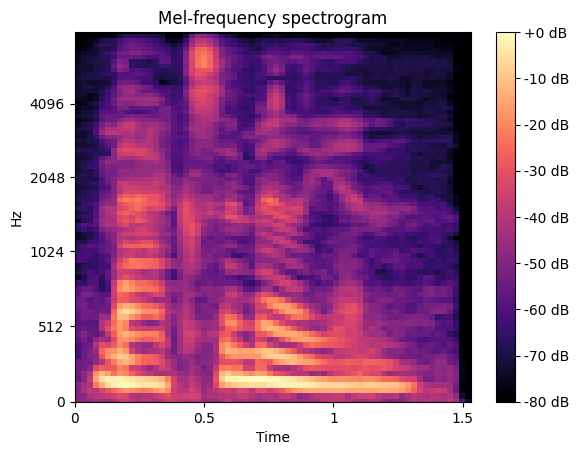

In [112]:
SR = 22050
params = {
    'n_fft': int(1024 * (SR / 16000)),
    'hop_length': int(256 * (SR / 16000)),
    'win_length': int(1024 * (SR / 16000)),
    'n_mels': 80
}

def load_spec(path, sample_rate, mel_params):
    y, _ = librosa.load(path, sr=sample_rate)
    return librosa.feature.melspectrogram(y, sr=sample_rate, **mel_params)

def graph_spec(spec, sample_rate):
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(spec, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel', sr=SR,
                             fmax=8000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')
    Audio(data=y, rate=SR)
    
spec = load_spec('../data/utterance_corpuses/LibriTTS/dev-clean/84/121123/84_121123_000007_000001.wav', SR, params)
graph_spec(spec, SR)

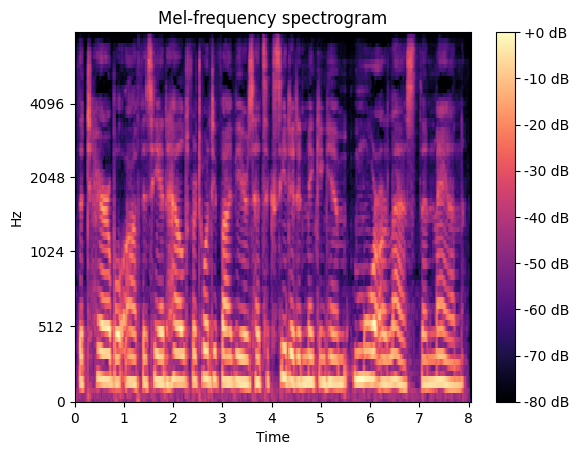

In [110]:
spec2 = load_spec('../data/utterance_corpuses/LibriTTS/dev-clean/84/121123/84_121123_000008_000001.wav', SR, params)
graph_spec(spec2, SR)

In [120]:
spec2.swapaxes(0, 1).shape

(347, 80)

In [223]:
from torch.utils.data import Dataset
import os

SR = 22050
params = {
    'n_fft': int(1024 * (SR / 16000)),
    'hop_length': int(256 * (SR / 16000)),
    'win_length': int(1024 * (SR / 16000)),
    'n_mels': 80
}

def load_spec(path, sample_rate, mel_params):
    y, _ = librosa.load(path, sr=sample_rate)
    return librosa.feature.melspectrogram(y, sr=sample_rate, **mel_params)


    
t = SpeakerAudioDataset('../data/utterance_corpuses/LibriTTS/dev-clean', sample_rate=SR, mel_params=params)

t[0]

('2412',
 array([[2.3618703e-09, 1.7308047e-08, 1.2743670e-08, ..., 2.8414000e-08,
         7.7849638e-09, 5.8486721e-10],
        [5.3309615e-09, 7.3057169e-09, 9.9221165e-09, ..., 2.7483299e-08,
         8.1792706e-09, 4.4168416e-10],
        [2.1275953e-08, 3.7122682e-08, 8.9364320e-08, ..., 2.4834673e-08,
         6.7856605e-09, 2.9146660e-10],
        ...,
        [9.5612108e-05, 1.4716693e-06, 2.5799752e-08, ..., 2.3722338e-08,
         9.3267634e-09, 4.3463694e-10],
        [1.5667601e-05, 1.2944737e-07, 1.8032660e-08, ..., 2.0468391e-08,
         7.5503559e-09, 2.8381419e-10],
        [5.5753694e-06, 5.3939907e-08, 1.6655953e-08, ..., 2.3148990e-08,
         5.5738676e-09, 4.6994802e-10]], dtype=float32))

In [71]:
# torch math init

class LSTMPCell(jit.ScriptModule):
    def __init__(self, input_size, hidden_size, projection_size):
        super(LSTMPCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.projection_size = projection_size
        self.weight_ih = Parameter(torch.randn(4 * hidden_size, input_size))
        self.weight_hh = Parameter(torch.randn(4 * hidden_size, projection_size))
        self.weight_hr = Parameter(torch.randn(projection_size, hidden_size))
        self.bias_ih = Parameter(torch.randn(4 * hidden_size))
        self.bias_hh = Parameter(torch.randn(4 * hidden_size))
        self.init_weights()

    @jit.script_method
    def forward(self, input, state):
        # type: (Tensor, Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tuple[Tensor, Tensor]]
        # input: batch_size * input_size
        # state: hx -> batch_size * projection_size 
        #        cx -> batch_size * hidden_size 
        # state cannot be None
        '''
        if state is not None:
            hx, cx = state
        else:
            hx = input.new_zeros(input.size(0), self.projection_size, requires_grad=False)
            cx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
        '''
        hx, cx = state
        gates = (torch.mm(input, self.weight_ih.t()) + self.bias_ih + 
                 torch.mm(hx, self.weight_hh.t()) + self.bias_hh)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        
        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * torch.tanh(cy)
        hy = torch.mm(hy, self.weight_hr.t())

        return hy, (hy, cy)
    
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        init.uniform_(self.weight_ih, -stdv, stdv)
        init.uniform_(self.weight_hh, -stdv, stdv)
        init.uniform_(self.weight_hr, -stdv, stdv)
        init.uniform_(self.bias_ih)
        init.uniform_(self.bias_hh)

In [121]:
rnn = nn.LSTM(80, 20, 2)
h0 = torch.randn(2, 20)
c0 = torch.randn(2, 20)
'''
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))
output'''

# features = mels (2)
# frames = frames (1)
# num frames = (0)

#x = torch.tensor()
#rnn(x, (h0, c0))
x = torch.tensor(spec.swapaxes(0,1))

rnn(x, (h0, c0))

(tensor([[-0.7617,  0.0871, -0.0255,  ..., -0.2190, -0.1666, -0.0683],
         [-0.4658,  0.1121,  0.0075,  ..., -0.0162, -0.1779,  0.0332],
         [-0.3406,  0.0678, -0.0021,  ...,  0.0720, -0.1832,  0.0593],
         ...,
         [-0.1102, -0.1160, -0.0123,  ...,  0.1542, -0.1177,  0.0898],
         [-0.1095, -0.1159, -0.0121,  ...,  0.1539, -0.1171,  0.0892],
         [-0.1092, -0.1159, -0.0120,  ...,  0.1538, -0.1167,  0.0888]],
        grad_fn=<SqueezeBackward1>),
 (tensor([[ 0.0674,  0.1115,  0.0108, -0.1910,  0.1481, -0.0861, -0.0476,  0.0554,
            0.1639,  0.0477,  0.0196,  0.0298, -0.0257, -0.1350, -0.1218, -0.1089,
            0.1860, -0.1084, -0.1181, -0.0286],
          [-0.1092, -0.1159, -0.0120,  0.0791, -0.1753,  0.0721, -0.0080,  0.1240,
            0.2163,  0.0130, -0.1243, -0.1265, -0.0980,  0.0033,  0.0856,  0.0861,
            0.1003,  0.1538, -0.1167,  0.0888]], grad_fn=<SqueezeBackward1>),
  tensor([[ 0.1438,  0.1995,  0.0233, -0.3622,  0.2781, -0.1827,

RuntimeError: input.size(-1) must be equal to input_size. Expected 80, got 66

In [224]:
from torch import nn

params = {
    'input_size': spec.shape[0],
    'hidden_size': 256,
    'projection_size': 256,
    'num_layers': 3
}

class SpeakerVerificationLSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, projection_size, num_layers):
        super(SpeakerVerificationLSTMEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.projection_size = projection_size
        
        self.hidden_layers = [
            LSTMPCell(self.input_size, self.hidden_size, self.projection_size)
            for i in range(0, num_layers)
        ]
        
        for h_l in self.hidden_layers:
            h_l.init_weights()
        
    def forward(self, x, hidden_state=None):
        
        for h_l in self.hidden_layers:
            x, hidden_state = h_l(x, hidden_state)
            
        return x
              
model = SpeakerVerificationLSTMEncoder(**params)

In [225]:
model(torch.tensor(test_X), torch.tensor(test_Y))

NameError: name 'test_X' is not defined

In [63]:
spec

array([[5.9299165e-04, 7.9402630e-04, 7.4597914e-04, ..., 2.1482082e-03,
        6.3002830e-05, 2.7518522e-06],
       [3.6011240e-04, 6.2066084e-04, 2.5742284e-03, ..., 8.4592775e-04,
        2.3675564e-06, 3.8192095e-08],
       [3.4753064e-04, 2.6261276e-03, 6.4610871e-03, ..., 1.3813368e-04,
        7.0984157e-07, 9.5869099e-09],
       ...,
       [2.4996729e-07, 6.8733800e-07, 8.7204194e-07, ..., 1.1941469e-07,
        5.9425815e-09, 3.1451202e-09],
       [7.6102353e-08, 1.6246048e-07, 2.2319060e-07, ..., 5.0079013e-08,
        3.9836130e-09, 2.0753850e-09],
       [6.0629692e-09, 7.9729272e-09, 8.9307566e-09, ..., 1.2066856e-09,
        9.3020390e-11, 1.5856473e-10]], dtype=float32)